In [215]:
import pandas as pd
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



# 형태소 분석기
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer

# windows 용 한글 폰트 오류 해결
from matplotlib import font_manager, rc

font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname = font_path).get_name()
rc("font", family = font_name)


# 정규표현식
import re 

# 문제

제시된 다산콜센터 데이터에서 “문서” 컬럼을 독립변수로 하여 “분류” 컬럼 을 예측하는 딥러닝 모델을 개발하고

모델 개발 과정과 테스트 데이터셋에 대한 loss를 답안으로 작성하시오

 

이때 주어진 데이터에서 학습용 데이터와 평가용 데이터를 분할할 때는 train_test_split 을 사용하고 학습 : 평가 비율이 7 : 3이 되게 하며, 종속변수에 대해 stratify 를 적용하고 random_state 는 34로 정한다

- 독립변수 : 문서컬럼
- 종속변수 : 분류컬럼

# 데이터 불러오기

In [156]:
df = pd.read_csv("./data/다산콜재단.csv", index_col=False)

In [157]:
df.shape

(2138, 6)

In [158]:
df.head()

,번호,분류,제목,내용,내용번호,문서
0,2645,복지,아빠 육아휴직 장려금,아빠 육아휴직 장려금 업무개요 남성근로자의 육아휴직을 장려하고 양육에 따른 경...,23522464,아빠 육아휴직 장려금아빠 육아휴직 장려금 업무개요 남성근로자의 육아휴직을 장려...
1,2644,경제,[서울산업진흥원] 서울메이드란?,서울산업진흥원 서울메이드란 서울의 감성을 담은 다양하고 새로운 경험을 제공하기 위해...,23194045,[서울산업진흥원] 서울메이드란?서울산업진흥원 서울메이드란 서울의 감성을 담은 다양하...
2,2642,복지,"광진맘택시 운영(임산부,영아 양육가정 전용 택시)",광진맘택시 운영임산부영아 양육가정 전용 택시 업무개요 교통약자인 임산부와 영아가정...,22904492,"광진맘택시 운영(임산부,영아 양육가정 전용 택시)광진맘택시 운영임산부영아 양육가정 ..."
3,2641,복지,마포 뇌병변장애인 비전센터,마포 뇌병변장애인 비전센터 마포뇌병변장애인 비전센터 운영 구분 내용 목적 학...,22477798,마포 뇌병변장애인 비전센터마포 뇌병변장애인 비전센터 마포뇌병변장애인 비전센터 운영 ...
4,2640,행정,2021년도 중1·고1 신입생 입학준비금 지원,년도 중고 신입생 입학준비금 지원 업무개요 서울시는 전국 최초로 년도부터 개 자...,22227896,2021년도 중1·고1 신입생 입학준비금 지원년도 중고 신입생 입학준비금 지원 업...


# 데이터 결측치 확인

In [159]:
df.isna().sum()

번호      0
분류      0
제목      0
내용      0
내용번호    0
문서      0
dtype: int64

## 독립변수 파악

In [160]:
x = df["문서"]

In [161]:
x.head()

0    아빠 육아휴직 장려금아빠 육아휴직 장려금   업무개요  남성근로자의 육아휴직을 장려...
1    [서울산업진흥원] 서울메이드란?서울산업진흥원 서울메이드란 서울의 감성을 담은 다양하...
2    광진맘택시 운영(임산부,영아 양육가정 전용 택시)광진맘택시 운영임산부영아 양육가정 ...
3    마포 뇌병변장애인 비전센터마포 뇌병변장애인 비전센터 마포뇌병변장애인 비전센터 운영 ...
4    2021년도 중1·고1 신입생 입학준비금 지원년도 중고 신입생 입학준비금 지원  업...
Name: 문서, dtype: object

In [162]:
# 중복데이터 확인
df[df["문서"].duplicated(keep=False)]

,번호,분류,제목,내용,내용번호,문서
649,1874,행정,불문경고도 소청심사의 대상이 되나요?,불문경고도 소청심사의 대상이 되나요불문경고는 신분상의 불이익을 초래하는 법률상의 효...,2895139,불문경고도 소청심사의 대상이 되나요?불문경고도 소청심사의 대상이 되나요불문경고는 신...
650,1873,행정,불문경고도 소청심사의 대상이 되나요?,불문경고도 소청심사의 대상이 되나요불문경고는 신분상의 불이익을 초래하는 법률상의 효...,2895150,불문경고도 소청심사의 대상이 되나요?불문경고도 소청심사의 대상이 되나요불문경고는 신...


- 중복데이터 있음 제거

- 기호 등 필요없는 문자열 제거 필요

## 종속변수 파악

In [169]:
y = df[["분류"]]

In [170]:
y.value_counts()

분류
행정    1098
경제     823
복지     217
Name: count, dtype: int64

- 3종류의 종속변수 확인
- 종속변수 비율이 균등하지 못함(성능이 좋지 않을시 언더샘플링고려)
- 출력층을 3개 softmax, loss 사용
- 종속변수 원핫인코딩으로 변환

### 종속변수 시각화

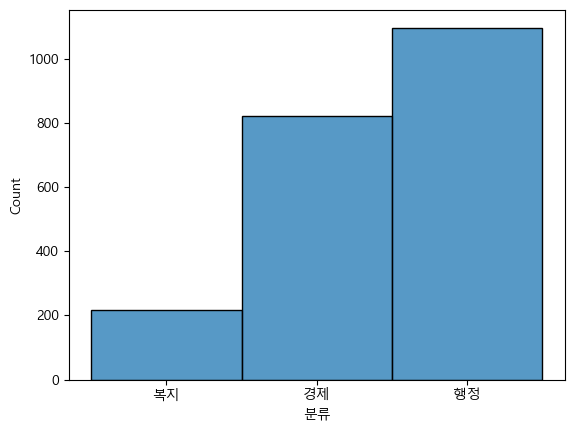

In [173]:
sns.histplot(df["분류"])
plt.show()

# 전처리

## 종속변수 전처리

In [108]:
df.loc[df["분류"] == "복지", "분류"] = 0
df.loc[df["분류"] == "경제", "분류"] = 1
df.loc[df["분류"] == "행정", "분류"] = 2

## 독립변수 전처리

In [102]:
# 독립변수 전처리
df["문서"] = df["문서"].str.replace("[^ㄱ-ㅎ가-힣ㅏ-ㅣ ]", " ", regex = True)
# 빈 문자열 제거
df = df[df["문서"].map(lambda x : len(x.strip()) >= 1)]
# 중복데이터제거
df = df.drop_duplicates(subset=["문서"])

In [103]:
df.shape

(2137, 6)

In [104]:
# 토큰화
okt = Okt() 

In [112]:
%%time
df["token"] = df["문서"].map(lambda x : okt.morphs(x, stem = True))

CPU times: total: 2min 22s
Wall time: 2min 9s


## 혹시 모르니 저장

In [113]:
#df.to_csv("./data/test.csv", index = False)

In [128]:
new_df = pd.read_csv("./data/test.csv", index_col = False)

In [192]:
new_df.head()

,번호,분류,제목,내용,내용번호,문서,token
0,2645,0,아빠 육아휴직 장려금,아빠 육아휴직 장려금 업무개요 남성근로자의 육아휴직을 장려하고 양육에 따른 경...,23522464,아빠 육아휴직 장려금아빠 육아휴직 장려금 업무개요 남성근로자의 육아휴직을 장려...,"['아빠', '육아휴직', '장려', '금', '아빠', '육아휴직', '장려', ..."
1,2644,1,[서울산업진흥원] 서울메이드란?,서울산업진흥원 서울메이드란 서울의 감성을 담은 다양하고 새로운 경험을 제공하기 위해...,23194045,서울산업진흥원 서울메이드란 서울산업진흥원 서울메이드란 서울의 감성을 담은 다양하...,"['서', '울', '산업', '진흥', '원', '서울', '메이드', '란', ..."
2,2642,0,"광진맘택시 운영(임산부,영아 양육가정 전용 택시)",광진맘택시 운영임산부영아 양육가정 전용 택시 업무개요 교통약자인 임산부와 영아가정...,22904492,광진맘택시 운영 임산부 영아 양육가정 전용 택시 광진맘택시 운영임산부영아 양육가정 ...,"['광진', '맘', '택시', '운영', '임산부', '영아', '양육', '가정..."
3,2641,0,마포 뇌병변장애인 비전센터,마포 뇌병변장애인 비전센터 마포뇌병변장애인 비전센터 운영 구분 내용 목적 학...,22477798,마포 뇌병변장애인 비전센터마포 뇌병변장애인 비전센터 마포뇌병변장애인 비전센터 운영 ...,"['마포', '뇌', '병변', '장애인', '비다', '센터', '마포', '뇌'..."
4,2640,2,2021년도 중1·고1 신입생 입학준비금 지원,년도 중고 신입생 입학준비금 지원 업무개요 서울시는 전국 최초로 년도부터 개 자...,22227896,년도 중 고 신입생 입학준비금 지원년도 중고 신입생 입학준비금 지원 업...,"['년도', '중', '고', '신입생', '입학', '준비', '금', '지원',..."


In [56]:
new_df[new_df["분류"] == "경제"]
new_df[new_df["분류"] == "행정"]

In [57]:
df

,번호,분류,제목,내용,내용번호,문서,token
0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...
2133,1,1,1,1,1,1,1
2134,2,2,2,2,2,2,2
2135,2,2,2,2,2,2,2
2136,2,2,2,2,2,2,2


In [47]:
keras.utils.to_categorical(df["분류"])

ValueError: invalid literal for int() with base 10: '복지'

In [ ]:
df["result"] = df["분류"]

In [33]:
# 혹시 모르니 저장
# df.to_csv("./data/test.csv", index = False)

In [58]:
# 다시 데이터 불러오기
new_df = pd.read_csv("./data/test.csv", index_col = False)

In [40]:
# 토큰화 된 애들 중 값이 없는 애들 제외
new_df = new_df[new_df["token"].map(lambda x :len (x) > 0 )]

In [41]:
# 바뀐 데이터 확인
new_df.head()

,번호,분류,제목,내용,내용번호,문서,token
0,2645,복지,아빠 육아휴직 장려금,아빠 육아휴직 장려금 업무개요 남성근로자의 육아휴직을 장려하고 양육에 따른 경...,23522464,아빠 육아휴직 장려금아빠 육아휴직 장려금 업무개요 남성근로자의 육아휴직을 장려...,"['아빠', '육아휴직', '장려', '금', '아빠', '육아휴직', '장려', ..."
1,2644,경제,[서울산업진흥원] 서울메이드란?,서울산업진흥원 서울메이드란 서울의 감성을 담은 다양하고 새로운 경험을 제공하기 위해...,23194045,서울산업진흥원 서울메이드란 서울산업진흥원 서울메이드란 서울의 감성을 담은 다양하...,"['서', '울', '산업', '진흥', '원', '서울', '메이드', '란', ..."
2,2642,복지,"광진맘택시 운영(임산부,영아 양육가정 전용 택시)",광진맘택시 운영임산부영아 양육가정 전용 택시 업무개요 교통약자인 임산부와 영아가정...,22904492,광진맘택시 운영 임산부 영아 양육가정 전용 택시 광진맘택시 운영임산부영아 양육가정 ...,"['광진', '맘', '택시', '운영', '임산부', '영아', '양육', '가정..."
3,2641,복지,마포 뇌병변장애인 비전센터,마포 뇌병변장애인 비전센터 마포뇌병변장애인 비전센터 운영 구분 내용 목적 학...,22477798,마포 뇌병변장애인 비전센터마포 뇌병변장애인 비전센터 마포뇌병변장애인 비전센터 운영 ...,"['마포', '뇌', '병변', '장애인', '비다', '센터', '마포', '뇌'..."
4,2640,행정,2021년도 중1·고1 신입생 입학준비금 지원,년도 중고 신입생 입학준비금 지원 업무개요 서울시는 전국 최초로 년도부터 개 자...,22227896,년도 중 고 신입생 입학준비금 지원년도 중고 신입생 입학준비금 지원 업...,"['년도', '중', '고', '신입생', '입학', '준비', '금', '지원',..."


- maxlen 150 정도가 괜찮아보임

# 데이터 나누기

In [182]:
x = new_df["token"]
y = new_df["분류"]

x_train, x_test, y_train, y_test = train_test_split(
    x
    ,y
    , test_size = 0.3
    , stratify = y 
    , random_state = 34 
)

In [183]:
x_train.shape, x_test.shape

((1495,), (642,))

# num_words 와 max_len 를 척도 알아보기

In [245]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(new_df["token"])

In [188]:
# 단어 몇개 있니?
word_index = tokenizer.word_index
len(word_index.keys())

11509

In [197]:
# 단어 등장 빈도가 2번 미만인 단어 수 제외하기
total_cnt = len(tokenizer.word_index)
rare_cnt = 0

for key, value in tokenizer.word_counts.items():
    if value < 2 :
        rare_cnt += 1

vocab_size = total_cnt - rare_cnt + 1        

In [198]:
vocab_size

7349

- 7349 개 정도 살아남았다

# max_len  정하기

In [255]:
lengths = np.array([len(i) for i in x_train])

In [256]:
np.mean(lengths), np.min(lengths), np.max(lengths), np.median(lengths)

(np.float64(105.30702341137123), np.int64(8), np.int64(1534), np.float64(68.0))

In [257]:
np.quantile(lengths, [0.1, 0.25, 0.5, 0.75, 0.9]) # 10퍼, 1사분위, 2사분위, 3사분위 ,90퍼

array([ 28. ,  41. ,  68. , 117. , 231.6])

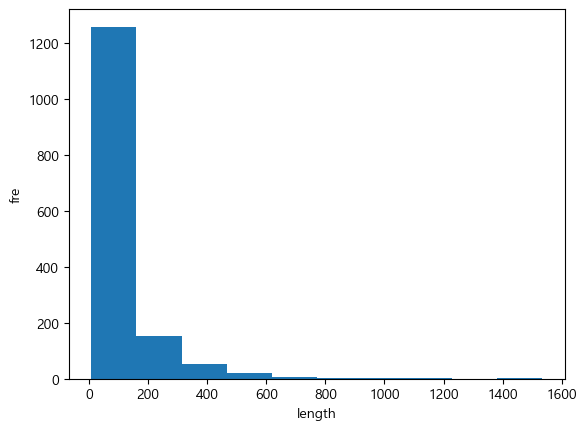

In [258]:
plt.figure()

plt.hist(lengths)

plt.xlabel("length")
plt.ylabel("fre")

plt.show()

In [203]:
# 다시 토큰화
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(new_df["token"])

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [204]:
x_sub, x_val, y_sub, y_val = train_test_split(
    x_train,
    y_train, 
    test_size = 0.3,
    stratify= y_train,
    random_state = 34
)

In [206]:
sub_seq.shape , val_seq.shape , test_seq.shape

((1046, 150), (449, 150), (642, 150))

In [259]:
# 기사와 성질이 같으므로 앞문장이 더 중요해 보임
sub_seq = pad_sequences(x_sub, maxlen = 150, truncating = "post")
val_seq = pad_sequences(x_val, maxlen = 150, truncating = "post")
test_seq = pad_sequences(x_test, maxlen = 150, truncating = "post")


sub_seq

array([[   0,    0,    0, ..., 1213,   42,   36],
       [   0,    0,    0, ...,  132,    1,    9],
       [   0,    0,    0, ...,   43,   45,   36],
       ...,
       [   0,    0,    0, ...,  189,   14,  230],
       [ 330,  256, 2557, ...,  193,   31,  524],
       [ 824,  223,   82, ...,    2,  314, 5188]],
      shape=(1046, 150), dtype=int32)

In [207]:
model = keras.Sequential()
model.add(keras.Input(shape = (150,)))


model.add(keras.layers.Embedding(vocab_size, 128))

model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Conv1D(64, 5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation(keras.activations.relu))
model.add(keras.layers.MaxPooling1D(4)) 

model.add(keras.layers.LSTM(128, dropout = 0.2))
model.add(keras.layers.Dropout(0.2))

# 출력층
model.add(keras.layers.Dense(3, activation= "softmax"))

In [208]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 150, 128)            │         940,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 150, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 146, 64)             │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 146, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 146, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 36, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,081,155 (4.12 MB)

 Trainable params: 1,081,027 (4.12 MB)

 Non-trainable params: 128 (512.00 B)

In [211]:
model.compile(optimizer= "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

es_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights=True)

In [212]:
history = model.fit(
    sub_seq, 
    y_sub, 
    epochs = 100,
    batch_size = 32, 
    validation_data = (val_seq, y_val), 
    callbacks = [es_cb]
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9379 - loss: 0.1842 - val_accuracy: 0.9488 - val_loss: 0.1744
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9751 - loss: 0.0817 - val_accuracy: 0.9599 - val_loss: 0.1434
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9857 - loss: 0.0451 - val_accuracy: 0.9555 - val_loss: 0.1341
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9837 - loss: 0.0455 - val_accuracy: 0.9555 - val_loss: 0.1342
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9914 - loss: 0.0257 - val_accuracy: 0.9488 - val_loss: 0.1470
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9847 - loss: 0.0374 - val_accuracy: 0.9465 - val_loss: 0.1650
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9895 - loss: 0.0335 - val_accuracy: 0.9599 - val_loss: 0.1432


- val_loss : 0.1341 / loss : loss: 0.0451

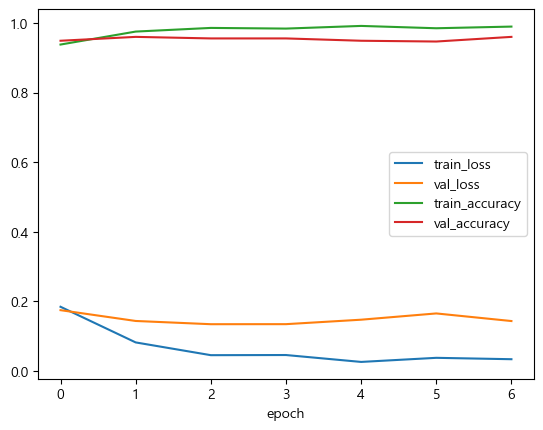

In [213]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["val_loss"], label = "val_loss")

plt.plot(history.history["accuracy"], label = "train_accuracy")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")

plt.legend()
plt.xlabel("epoch")
plt.show()

# 일반화 점수

In [240]:
model.evaluate(test_seq, y_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7788 - loss: 0.6469 


[0.6468666791915894, 0.7788162231445312]

In [250]:
def sent_predict(text): 
    text = re.sub(r"[^ㄱ-ㅎ가-힣ㅏ-ㅣ]", " ", text)
    okt = Okt()
    text = okt.morphs(text, stem = True)

    
    encoded = tokenizer.texts_to_sequences([text])
    pad_new = pad_sequences(encoded, maxlen = 150)
    score = max(model.predict(pad_new))

    return score

In [251]:
sent_predict("엥 복지!!! 이건 복지!!!")

[[]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([0.24356388, 0.4529762 , 0.30346   ], dtype=float32)

- 복지= 0
- 경제 = 1
- 행정 = 2